In [1]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
import ast
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib import pyplot as plt
import os
import shutil
from datetime import datetime
import wandb

In [2]:
# 方便复现结果
def set_all_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # 如果使用 GPU，也需要固定 CUDA 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果有多个 GPU
set_all_seed(42)

In [3]:
# 前25个特征是离散特征，后13个特征是连续特征
df_train=pd.read_csv("data/exp1/raw_train.csv")
df_test=pd.read_csv("data/exp1/raw_test.csv")

In [4]:
df_train['vectorized_features_1'] = df_train['vectorized_features_1'].apply(ast.literal_eval)
df_test['vectorized_features_1'] = df_test['vectorized_features_1'].apply(ast.literal_eval)

In [5]:
# 获取训练数据
x_train=torch.from_numpy(np.array(df_train['vectorized_features_1'].values.tolist(),np.float32))
x_train_d=x_train[:,:25].long() # 前25维是离散变量(discrete)，要转为long类型才能送入embedding层
x_train_c=x_train[:,25:] # 中间13维是连续变量(continuous), 最后一维是0或1，也当做连续变量
y1_train=torch.from_numpy(np.array(df_train['income'].values.tolist(),np.float32))
y2_train=torch.from_numpy(np.array(df_train['AMARITL'].values.tolist(),np.float32))

print(x_train_d)
print(x_train_d.shape)
print(x_train_c)
print(x_train_c.shape)
print(y1_train)
print(y1_train.shape)
print(y2_train)
print(y2_train.shape)

tensor([[2, 6, 6,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 5,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [5, 7, 3,  ..., 0, 0, 0]])
torch.Size([95130, 25])
tensor([[58.,  4., 34.,  ..., 52., 94.,  0.],
        [ 9.,  0.,  0.,  ...,  0., 94.,  0.],
        [10.,  0.,  0.,  ...,  0., 94.,  0.],
        ...,
        [51., 33., 19.,  ..., 52., 94.,  0.],
        [ 3.,  0.,  0.,  ...,  0., 94.,  0.],
        [65., 37.,  2.,  ..., 52., 94.,  0.]])
torch.Size([95130, 14])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([95130])
tensor([0., 1., 1.,  ..., 0., 1., 0.])
torch.Size([95130])


计算两个任务的标签间的pearson相关系数

In [6]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(y1_train, y2_train)
print(f"Absolute Pearson correlation coefficient: {abs(corr)}") # 符合原论文的0.1768
print(f"P-value: {p_value}")

Absolute Pearson correlation coefficient: 0.17716269850240274
P-value: 0.0


In [7]:
# 获取测试数据
x_test=torch.from_numpy(np.array(df_test['vectorized_features_1'].values.tolist(),np.float32))
x_test_d=x_test[:,:25].long() # 前25维是离散变量(discrete)，要转为long类型才能送入embedding层
x_test_c=x_test[:,25:] # 中间13维是连续变量(continuous), 最后一维是0或1，也当做连续变量
y1_test=torch.from_numpy(np.array(df_test['income'].values.tolist(),np.float32))
y2_test=torch.from_numpy(np.array(df_test['AMARITL'].values.tolist(),np.float32))

print(x_test_d)
print(x_test_d.shape)
print(x_test_c)
print(x_test_c.shape)
print(y1_test)
print(y1_test.shape)
print(y2_test)
print(y2_test.shape)

tensor([[ 1,  9,  4,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 1,  3,  1,  ...,  0,  0,  0],
        [ 2, 14, 10,  ...,  1,  2,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])
torch.Size([47391, 25])
tensor([[35., 29.,  3.,  ..., 52., 94.,  0.],
        [13.,  0.,  0.,  ...,  0., 94.,  0.],
        [ 1.,  0.,  0.,  ...,  0., 94.,  0.],
        ...,
        [22., 43., 26.,  ..., 52., 94.,  1.],
        [24.,  1., 43.,  ..., 52., 94.,  0.],
        [67.,  0.,  0.,  ...,  0., 94.,  0.]])
torch.Size([47391, 14])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([47391])
tensor([0., 1., 1.,  ..., 1., 0., 0.])
torch.Size([47391])


In [8]:
class MyDataset(Dataset):
    def __init__(self,x_discrete,x_continuous,y1,y2):
        self.x_d=x_discrete
        self.x_c=x_continuous
        self.y1=y1
        self.y2=y2
    def __len__(self):
        return self.x_d.shape[0]
    def __getitem__(self,idx):
        return (self.x_d[idx],self.x_c[idx],self.y1[idx],self.y2[idx])

In [9]:
# 训练集
train_dataset=MyDataset(x_train_d,x_train_c,y1_train,y2_train)
# 验证集和测试集按照原论文1:1
val_dataset=MyDataset(x_test_d[:23695],x_test_c[:23695],y1_test[:23695],y2_test[:23695])
test_dataset=MyDataset(x_test_d[23695:47390],x_test_c[23695:47390],y1_test[23695:47390],y2_test[23695:47390])

In [10]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

class Expert(nn.Module):
    def __init__(self, input_dim, output_dim, expert_dropout):  # input_dim代表输入维度，output_dim代表输出维度
        super(Expert, self).__init__()

        expert_hidden_layers = [16, 8]
        self.expert_layer = nn.Sequential(
            nn.Linear(input_dim, expert_hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[0], expert_hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[1], output_dim),
            nn.ReLU(),
            nn.Dropout(expert_dropout)
        )

    def forward(self, x):
        out = self.expert_layer(x)
        return out


class Dispatcher(object):
    # gates是一个(batch_size,num_experts)的张量，表示batch内数据在各expert上的权重
    def __init__(self, num_experts, gates):
        self.gates = gates
        self.num_experts = num_experts

        nonzero_gates_index = torch.nonzero(gates)

        # nonzero_gates_index的第二列表示expert的下标，按照第二列排序，就是按照expert下标排序
        # 按照expert下标排序，是为了让每个expert接收的样本连在一起，方便构造每个expert的输入
        sorted_indices = torch.argsort(nonzero_gates_index[:, 1])
        self.nonzero_gates_index = nonzero_gates_index[sorted_indices]

        self.batch_index = self.nonzero_gates_index[:, 0]  # 第一列表示batch下标，即batch内第几个样本
        self.expert_index = self.nonzero_gates_index[:, 1]  # 第二列表示expert下标

        self.nonzero_gates = gates[self.batch_index, self.expert_index]  # 按照expert顺序排序的非零权重
        self.num_samples_per_expert = (gates > 0).sum(0).tolist()  # 每个expert接收的样本数

    def dispatch(self, x):
        # 输入为(B,d)的小批次样本
        # 输出为一个列表，列表中第i个元素是一个shape为(第i个expert接收的样本数, d)的张量
        x_expand = x[self.batch_index]
        dispatch_output = torch.split(x_expand, self.num_samples_per_expert, dim=0)  # 按照self.part_sizes分割
        return dispatch_output

    def combine(self, expert_out):
        expert_out = torch.cat(expert_out, dim=0)
        weighted_expert_out = expert_out * self.nonzero_gates.unsqueeze(1)
        zero_tensor = torch.zeros(self.gates.shape[0], expert_out.shape[1], device=expert_out.device)  # (B,d)
        combined = zero_tensor.index_add(0, self.batch_index, weighted_expert_out)
        return combined

    def expert_to_gates(self):
        # 分割出每个expert的非零权重，返回一个list，每个元素是一个shape为(第i个expert接收的样本数,)的张量
        return torch.split(self.nonzero_gates, self.num_samples_per_expert, dim=0)


class SparseMMoE(nn.Module):
    def __init__(self, input_size, output_size, num_experts, n_task, load_balancing_loss_coef,
                 expert_dropout=0.1, noisy_gating=True, k=2):
        super(SparseMMoE, self).__init__()
        self.noisy_gating = noisy_gating  # 在gate权重上加入噪音, 可以打破平局时的均衡
        self.num_experts = num_experts
        self.input_size = input_size
        self.output_size = output_size
        self.expert_dropout=expert_dropout
        self.n_task=n_task
        self.k = k
        self.load_balancing_loss_coef=load_balancing_loss_coef
        self.experts = nn.ModuleList([Expert(self.input_size, self.output_size, self.expert_dropout) for i in range(self.num_experts)])
        # 将w_gate和w_noise全部初始化为全0，保证初始时通过noise选择expert
        self.w_gates = nn.ParameterList([nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True) for _ in range(n_task)])
        self.b_gates = nn.ParameterList([nn.Parameter(torch.zeros(num_experts), requires_grad=True) for _ in range(n_task)])
        self.w_noises = nn.ParameterList([nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True) for _ in range(n_task)])
        self.b_noises = nn.ParameterList([nn.Parameter(torch.zeros(num_experts), requires_grad=True) for _ in range(n_task)])

        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=1)
        self.normal=Normal(0.0,1.0)
        assert (self.k <= self.num_experts)

    # cv即coefficient of variation(变异系数), cv(x)**2 = x的方差/(x的均值**2)
    # 计算cv_squared是为了计算load balancing loss
    # 参考 https://arxiv.org/pdf/1701.06538
    def cv_squared(self, x):
        """
        The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        """
        eps = 1e-10
        # if num_experts = 1
        if x.shape[0] == 1:
            return torch.tensor([0], device=x.device, dtype=x.dtype)

        # 因为gates_to_load返回的是真实负载，是整数。所以这里要用float()
        return x.float().var() / (x.float().mean() ** 2 + eps)

    def gates_to_load(self, gates):
        """
        计算每个expert的真实负载，即接收了多少个样本(或者说在小批次数据内有多少个样本在该expert上的权重大于0)
        """
        return (gates > 0).sum(dim=0)

    def prob_in_top_k(self, clean_values, noisy_values, noise_stddev):
        """
        Computes the probability that value is in top k, given different random noise.
        Args:
        clean_values: a `Tensor` of shape [batch, num_epxerts].
        noisy_values: a `Tensor` of shape [batch, num_epxerts].  Equal to clean values plus
          normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, num_epxerts]
        Returns:
        a `Tensor` of shape [batch, num_epxerts].
        """

        noisy_topk_values, _ = torch.topk(noisy_values, self.k + 1)

        top_k_plus_1_values = noisy_topk_values[:, [-1]]
        prob_topk = self.normal.cdf((clean_values - top_k_plus_1_values) / noise_stddev)
        top_k_values = noisy_topk_values[:, [-2]]
        prob_after_topk = self.normal.cdf((clean_values - top_k_values) / noise_stddev)

        # 如果比top_k_plus_1_values大，就说明在topk内
        in_topk = torch.gt(noisy_values, top_k_plus_1_values)

        # 对于前k大值，除自身以外的第k大值就是第k+1大值，所以选择prob_topk
        # 对于非topk的值，除自身以外的第k大值就是第k大值，所以选择prob_after_topk
        prob = torch.where(in_topk, prob_topk, prob_after_topk)

        return prob

    def noisy_top_k_gating(self, x, train, taks_id, noise_epsilon=1e-2):
        """
          Args:
            x: input Tensor with shape [batch_size, input_size]
            train: a boolean - we only add noise at training time.
            noise_epsilon: a float
          Returns:
            gates: a Tensor with shape [batch_size, num_experts]
            load: a Tensor with shape [num_experts]
        """
        clean_logits = x @ self.w_gates[taks_id] + self.b_gates[taks_id]
        if self.noisy_gating and train:
            raw_noise_stddev = x @ self.w_noises[taks_id] + self.b_noises[taks_id]
            noise_stddev = self.softplus(raw_noise_stddev) + noise_epsilon  # 为了数值稳定
            noisy_logits = clean_logits + (torch.randn_like(clean_logits) * noise_stddev)
            logits = noisy_logits
        else:
            logits = clean_logits

        # calculate topk + 1 that will be needed for the noisy gates
        top_k_logits, top_k_indices = logits.topk(self.k, dim=1)
        top_k_gates = self.softmax(top_k_logits)

        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gates)

        if self.noisy_gating and self.k < self.num_experts and train:
            # 这里的load_i指的是第i个expert被batch内各样本激活概率的和
            load = (self.prob_in_top_k(clean_logits, noisy_logits, noise_stddev)).sum(0)
        else:
            # 这里的load是真实负载
            load = self.gates_to_load(gates)
        return gates, load

    def forward(self, x):
        load_balancing_loss=0
        outputs=[]
        for i in range(self.n_task):
            gates, load = self.noisy_top_k_gating(x, self.training, i)
            # 记录每个batch内各expert的平均门网络的输出
            for j in range(self.num_experts):
                writer.add_scalar(f"task_{i}/expert_{j}_weight", gates[:,j].mean(), tot_iters)

            # calculate importance loss
            importance = gates.sum(0)
            # load_balancing_loss = importance_loss + load_loss
            task_load_balancing_loss = self.cv_squared(importance) + self.cv_squared(load)
            load_balancing_loss=load_balancing_loss+task_load_balancing_loss*self.load_balancing_loss_coef

            dispatcher = Dispatcher(self.num_experts, gates)
            expert_inputs = dispatcher.dispatch(x)
            # gates = dispatcher.expert_to_gates()
            expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
            y = dispatcher.combine(expert_outputs)
            outputs.append(y)
        return outputs, load_balancing_loss

In [11]:
class MyModel(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)
    def __init__(self, feature_dim, expert_dim, n_expert, n_activated_expert, n_task,
                 load_balancing_loss_coef, tower_dropout=0, expert_dropout=0):
        super(MyModel, self).__init__()

        self.n_task = n_task

        self.sparse_mmoe = SparseMMoE(input_size=feature_dim,
                                     output_size=expert_dim,
                                     num_experts=n_expert,
                                     n_task=n_task,
                                     expert_dropout=expert_dropout,
                                     load_balancing_loss_coef=load_balancing_loss_coef,
                                     noisy_gating=True,
                                     k=n_activated_expert)

        # 对于离散变量做embedding
        # 25种离散变量
        vocab_size_list = [9,24,15,5,10,2,3,6,1,6,6,50,37,8,9,8,9,3,3,5,40,40,41,5,3]
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=i, embedding_dim=4) for i in vocab_size_list
        ])
        # 合计送入expert的维度为:25*4+14=114

        # 顶层的任务塔
        hidden_layer1 = [8, 4]
        self.towers=nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, hidden_layer1[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer1[0], hidden_layer1[1]),
                nn.ReLU(),
                nn.Dropout(tower_dropout),
                nn.Linear(hidden_layer1[1], 1))
            for i in range(n_task)
        ])
        
        self.sigmoid=nn.Sigmoid()

    def forward(self, x_d, x_c):
        temp = []
        for i in range(len(self.embeddings)):
            temp.append(self.embeddings[i](x_d[:, i]))
        temp = temp + [x_c]
        x = torch.cat(temp, dim=-1)

        towers_input, load_balancing_loss= self.sparse_mmoe(x)

        outputs = []
        for i in range(self.n_task):
            outputs.append(self.sigmoid(self.towers[i](towers_input[i])))

        return outputs, load_balancing_loss

In [12]:
# model config
feature_dim=114
expert_dim=32
n_expert=16
n_activated_expert=4
n_task=2
gate_dropout=0 # 无dropout
tower_dropout=0
expert_dropout=0
load_balancing_loss_coef=1e-2

# train config
batch_size=256
N_epochs=50
lr=0.0001

model_name="exp1_SparseMMoE"

log_dir = f"logs/"+model_name+"/"\
+f"lr={lr}_N_epochs={N_epochs}_batch_size={batch_size}_n_expert={n_expert}_n_activated_expert={n_activated_expert}_"\
+f"n_task={n_task}_expert_dropout={expert_dropout}_tower_dropout={tower_dropout}_"\
+f"load_balancing_loss_coef={load_balancing_loss_coef}"

bestmodel_save_dir = f"model/"+model_name+"/"\
+f"lr={lr}_N_epochs={N_epochs}_batch_size={batch_size}_n_expert={n_expert}_n_activated_expert={n_activated_expert}_"\
+f"n_task={n_task}_expert_dropout={expert_dropout}_tower_dropout={tower_dropout}_"\
+f"load_balancing_loss_coef={load_balancing_loss_coef}"

if os.path.exists(log_dir):
    shutil.rmtree(log_dir, ignore_errors=True) # tensorboard默认会追加新的日志，而非覆盖，通过删除日志目录，实现覆盖日志

print(log_dir)
print(bestmodel_save_dir)

logs/exp1_SparseMMoE/lr=0.0001_N_epochs=50_batch_size=256_n_expert=16_n_activated_expert=4_n_task=2_expert_dropout=0_tower_dropout=0_load_balancing_loss_coef=0.01
model/exp1_SparseMMoE/lr=0.0001_N_epochs=50_batch_size=256_n_expert=16_n_activated_expert=4_n_task=2_expert_dropout=0_tower_dropout=0_load_balancing_loss_coef=0.01


In [13]:
mymodel = MyModel(feature_dim=feature_dim,
                  expert_dim=expert_dim,
                  n_expert=n_expert,
                  n_activated_expert=n_activated_expert,
                  n_task=n_task, 
                  expert_dropout=expert_dropout, 
                  tower_dropout=tower_dropout,
                  load_balancing_loss_coef=load_balancing_loss_coef,
                 )

nParams = sum([p.nelement() for p in mymodel.parameters()])
print('Number of parameters: %d' % nParams)

nParams_in_mmoe=0
for name,p in mymodel.named_parameters():
    if name.startswith("sparse_mmoe"):
        nParams_in_mmoe=nParams_in_mmoe+p.nelement()
print('Number of parameters in SparseMMoE: %d' % nParams_in_mmoe)
# 相比于MMOE增加了w_noises和b_noises
print(f'Number of activated parameters in SparseMMoE: {int(nParams_in_mmoe*n_activated_expert/n_expert)}')

Number of parameters: 45586
Number of parameters in SparseMMoE: 43584
Number of activated parameters in SparseMMoE: 10896


In [14]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [15]:
if not os.path.exists("model/"+model_name):
    os.makedirs("model/"+model_name) 

In [16]:
def train(mymodel, lr, N_epochs, batch_size):
    global writer
    writer = SummaryWriter(log_dir=log_dir)
    global tot_iters
    tot_iters = 0
    mymodel = mymodel.to(device)
    loss_fun = nn.BCELoss()
    optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
    adam_batch_loss = []
    losses = []
    val_losses = []
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(N_epochs):
        # train loop
        batch_loss = []
        mymodel.train()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in train_dataloader:
            tot_iters+=1
            
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            [y1_pred, y2_pred], load_balancing_loss = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)
            
            loss1 = loss_fun(y1_pred, y1_batch)
            loss2 = loss_fun(y2_pred, y2_batch)
            writer.add_scalar(f"loss1", loss1, tot_iters)
            writer.add_scalar(f"loss2", loss2, tot_iters)
            writer.add_scalar(f"load_balancing_loss", load_balancing_loss, tot_iters)
            loss = loss1+loss2+load_balancing_loss  # 此处令两个任务的损失值权重均为1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record result
            adam_batch_loss.append(loss.detach().cpu().numpy())
            batch_loss.append(loss.detach().cpu().numpy())

        # val loop
        val_batch_loss = []
        mymodel.eval()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in val_dataloader:
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            [y1_pred, y2_pred], load_balancing_loss = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)

            loss = loss_fun(y1_pred, y1_batch) + loss_fun(y2_pred, y2_batch)+load_balancing_loss

            # record result
            val_batch_loss.append(loss.detach().cpu().numpy())

        # post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))

        # print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
        writer.add_scalar(f"train_loss", losses[-1], epoch)
        writer.add_scalar(f"val_loss", val_losses[-1], epoch)

        # save best model
        if (val_losses[-1] < best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(), bestmodel_save_dir)
            best_loss = val_losses[-1]
    
    writer.close()

    return losses, val_losses, adam_batch_loss

In [17]:
losses, val_losses, adam_batch_loss= train(mymodel=mymodel, lr=lr, N_epochs=N_epochs, batch_size=batch_size)

Epoch=0,train_loss=0.8671926259994507,val_loss=0.5516029000282288
current epoch is the best so far. Saving model...
Epoch=1,train_loss=0.45372065901756287,val_loss=0.40666791796684265
current epoch is the best so far. Saving model...
Epoch=2,train_loss=0.3687489628791809,val_loss=0.35081249475479126
current epoch is the best so far. Saving model...
Epoch=3,train_loss=0.3378540277481079,val_loss=0.32062962651252747
current epoch is the best so far. Saving model...
Epoch=4,train_loss=0.32420074939727783,val_loss=0.3260929584503174
Epoch=5,train_loss=0.3152298629283905,val_loss=0.3038378655910492
current epoch is the best so far. Saving model...
Epoch=6,train_loss=0.3056662082672119,val_loss=0.3075053095817566
Epoch=7,train_loss=0.2993360757827759,val_loss=0.30006927251815796
current epoch is the best so far. Saving model...
Epoch=8,train_loss=0.2926027476787567,val_loss=0.3060711920261383
Epoch=9,train_loss=0.2880065441131592,val_loss=0.2823554277420044
current epoch is the best so far. 

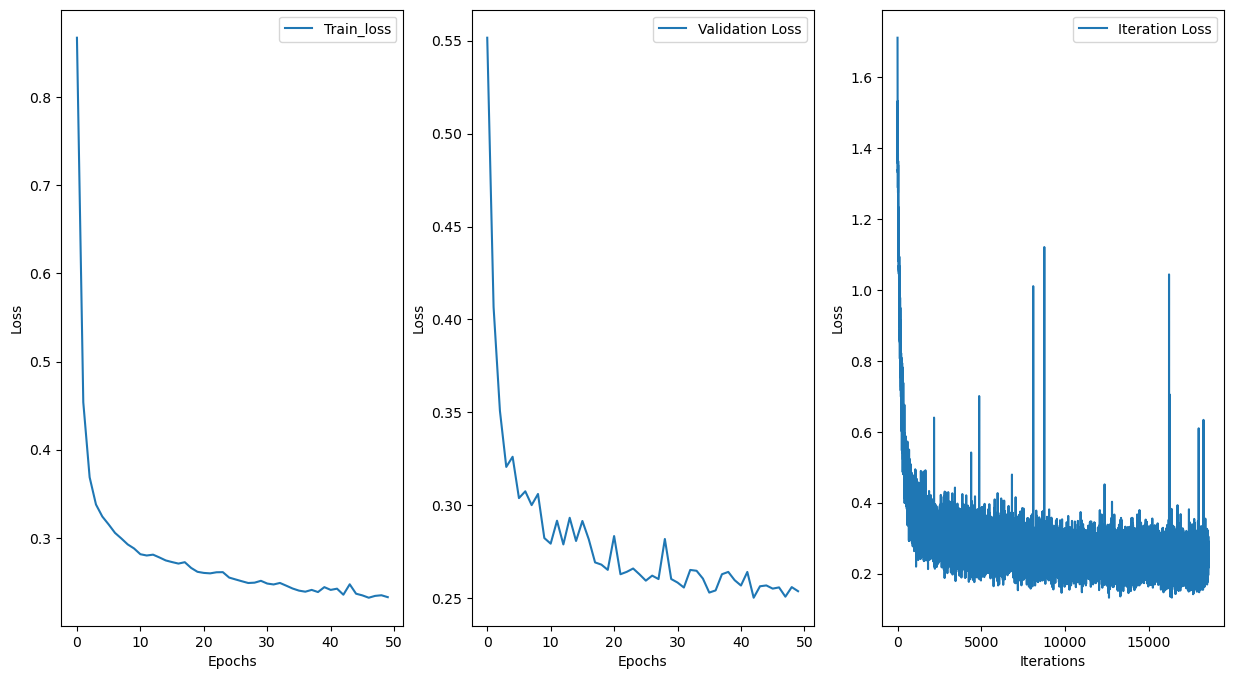

In [18]:
# visualization
fix,axes=plt.subplots(nrows=1,ncols=3,figsize=(15, 8))

axes[0].plot(range(N_epochs),losses,label="Train_loss")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# axes[1].plot(range(N_epochs),best_model_loss[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),val_losses,label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(range(tot_iters),adam_batch_loss,label="Iteration Loss")
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Loss')
axes[2].legend()

In [19]:
# load best model based on validation
mybestmodel = MyModel(feature_dim=feature_dim,
                      expert_dim=expert_dim,
                      n_expert=n_expert,
                      n_activated_expert=n_activated_expert,
                      n_task=n_task, 
                      expert_dropout=expert_dropout, 
                      tower_dropout=tower_dropout,
                      load_balancing_loss_coef=load_balancing_loss_coef
                     )
mybestmodel.load_state_dict(torch.load(bestmodel_save_dir))
mybestmodel=mybestmodel.to(device)
mybestmodel.eval()

x_test_d, x_test_c=x_test_d.to(device), x_test_c.to(device)

[y1_pred, y2_pred], load_balancing_loss = mybestmodel(x_test_d[23695:47390],x_test_c[23695:47390])

# y1_pred=(y1_pred>0.5).int()
# y2_pred=(y2_pred>0.5).int()

y1_pred=y1_pred.squeeze(1).detach().cpu().numpy()
y2_pred=y2_pred.squeeze(1).detach().cpu().numpy()

In [20]:
from sklearn.metrics import roc_curve, auc

def get_auc(y_true,y_pred):
    # 获取 ROC 曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # 计算 AUC
    calculated_auc = auc(fpr, tpr)
    print(f"Custom AUC: {calculated_auc}")
    return calculated_auc

In [21]:
auc1=get_auc(y1_test[23695:47390],y1_pred)
auc2=get_auc(y2_test[23695:47390],y2_pred)

Custom AUC: 0.937475631927881
Custom AUC: 0.9915596195039037


In [22]:
y1_test[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
y1_pred[:10]

array([8.16580653e-02, 2.72078179e-02, 4.64988352e-06, 1.12694470e-05,
       1.55024332e-04, 2.10736301e-02, 2.85965274e-03, 1.17695995e-01,
       4.69269609e-04, 6.17782399e-03], dtype=float32)

In [24]:
y2_pred[:10]

array([2.85402649e-07, 1.68219730e-01, 9.99999285e-01, 9.99962926e-01,
       9.95297730e-01, 4.18005399e-08, 1.18866206e-08, 1.13748424e-01,
       2.57897731e-02, 2.65861899e-01], dtype=float32)

In [25]:
y2_test[:10]

tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])